In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pdb
import copy

import sys
sys.path.append("..")
sys.path.append("../third_party")


from cln import data
from cln import contamination
from cln.AP_identification import AnchorPointsIdentification
from cln.T_estimation import evaluate_estimate, TMatrixEstimation
from third_party import arc

In [2]:
# Define default parameters
exp_num = 801
data_name = 'synthetic1'
num_var = 20
K = 4
signal = 1
model_name = 'RFC'
epsilon = 0.2
nu = 0
contamination_model = "uniform"
n_train = 10000
n_cal = 5000
seed = 1

# Define other constant parameters
batch_size = 20
gamma_vec = np.asarray([0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2], dtype=float)

In [3]:
# Initialize the data distribution
if data_name == "synthetic1":
    data_distribution = data.DataModel_1(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic2":
    data_distribution = data.DataModel_2(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic3":
    data_distribution = data.DataModel_3(K, num_var, signal=signal, random_state=seed)
else:
    print("Unknown data distribution!")
    sys.stdout.flush()
    exit(-1)

In [4]:
# Initialize noise contamination process
if contamination_model == "uniform":
    T = contamination.construct_T_matrix_simple(K, epsilon)
elif contamination_model == "block":
    T = contamination.construct_T_matrix_block(K, epsilon)
elif contamination_model == "RRB":
    T = contamination.construct_T_matrix_block_RR(K, epsilon, nu)
elif contamination_model == "random":
    T = contamination.construct_T_matrix_random(K, epsilon, random_state=seed)
else:
    print("Unknown contamination (M) model!")
    sys.stdout.flush()
    exit(-1)

In [5]:
# Initialize black-box model
if model_name == 'RFC':
    black_box = arc.black_boxes.RFC(n_estimators=100, max_features="sqrt")
elif model_name == 'SVC':
    black_box = arc.black_boxes.SVC(clip_proba_factor = 1e-5)
elif model_name == 'NN':
    black_box = arc.black_boxes.NNet(max_iter=100)
elif model_name == 'MF':
    black_box = DummyClassifier(strategy="most_frequent")
elif model_name == 'SRC':
    black_box = DummyClassifier(strategy="stratified")
else:
    print("Unknown model!")
    sys.stdout.flush()
    exit(-1)

In [6]:
# Add important parameters to table of results
header = pd.DataFrame({'data':[data_name], 'num_var':[num_var], 'K':[K],
                       'signal':[signal], 'n_train':[n_train], 'n_cal':[n_cal],
                       'epsilon':[epsilon], 'nu':[nu], 'contamination':[contamination_model],
                       'model_name':[model_name],
                       'seed':[seed]})

# Output file
outfile_prefix = "exp"+str(exp_num) + "/" + data_name + "_p" + str(num_var)
outfile_prefix += "_K" + str(K) + "_signal" + str(signal) + "_" + model_name
outfile_prefix += "_eps" + str(epsilon) + "_nu" + str(nu) + "_" + contamination_model
outfile_prefix += "_nt" + str(n_train) + "_nc" + str(n_cal) + "_seed" + str(seed)
print("Output file: {:s}.".format("results/"+outfile_prefix), end="\n")
sys.stdout.flush()

Output file: results/exp801/synthetic1_p20_K4_signal1_RFC_eps0.2_nu0_uniform_nt10000_nc5000_seed1.


## Repeated experiments

In [7]:
# Describe the experiment
def run_experiment(random_state):
    print("\nRunning experiment in batch {:d}...".format(random_state))
    sys.stdout.flush()

    # Generate a large data set
    print("\nGenerating data...", end=' ')
    sys.stdout.flush()
    data_distribution.set_seed(random_state+1)
    X, Y = data_distribution.sample(n_train+n_cal)
    print("Done.")
    sys.stdout.flush()

    # Generate the contaminated labels
    print("Generating contaminated labels...", end=' ')
    sys.stdout.flush()
    contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+2)
    Yt = contamination_process.sample_labels(Y)
    print("Done.")
    sys.stdout.flush()

    # Separate data into training and calibration
    X_train, X_cal, _, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal, random_state=random_state+3)

    # Fit the point predictor on the training set
    black_box_pt = copy.deepcopy(black_box)
    black_box_pt.fit(X_train, Yt_train)

    methods = {
        "D2L": lambda: AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, calibrate_gamma=True, gamma_vec=gamma_vec, elbow_detection_method="D2L"),

        "drop1": lambda: AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, calibrate_gamma=True, gamma_vec=gamma_vec, elbow_detection_method="drop", drop=0.01),

        "threshold": lambda: AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, gamma=(20*K/n_cal)),

        "top1perc": lambda: AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, gamma=0.01),

        "D2L filtered": lambda: AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, calibrate_gamma=True, gamma_vec=gamma_vec, elbow_detection_method="D2L", ap_filter=True, filter_method="mahalanobisdepth")
    }

    # Initialize an empty list to store the evaluation results
    res = pd.DataFrame({})
    res_list = []

    # Estimate using all the clean/noisy labels correspondence
    T_hat_clean = np.zeros((K, K), dtype=float)
    for l in range(K):
        idx = (Y_cal == l)
        n_l = np.sum(idx)
        if n_l > 0:
            counts = np.bincount(Yt_cal[idx], minlength=K)
            T_hat_clean[:, l] = counts / n_l
        else:
            # Fallback if a class i does not appear in Y_train2
            T_hat_clean[:, l] = np.ones(K) / K
    col_sums = T_hat_clean.sum(axis=0, keepdims=True)
    T_hat_clean /= col_sums
    epsilon_hat = (1-T_hat_clean[0,0])*K/(K-1)

    performances = evaluate_estimate(T, T_hat_clean)
    performances['epsilon_res'] = epsilon_hat - epsilon
    res_update = header.copy()
    res_update = res_update.assign(Method='Clean sample', n_eq=n_cal, **performances)
    res_list.append(res_update)

    # # Estimate using n_equivalent samples with clean/noisy labels correspondence
    # n_eq = int(np.round(n_cal * gamma * K))
    # T_hat_n_eq = np.zeros((K, K), dtype=float)
    # for l in range(K):
    #     idx_l = (Y_cal == l)
    #     Yt_cal_l = Yt_cal[idx_l]
    #     n_l = len(Yt_cal_l)
    #     n_l_eq = min(n_l,int(np.ceil(n_cal * gamma)))
    #     if n_l_eq==n_l:
    #         Yt_cal_l_eq = Yt_cal_l
    #     else:
    #         _,Yt_cal_l_eq = train_test_split(Yt_cal_l, test_size=n_l_eq, random_state=random_state+3)

    #     if n_l_eq > 0:
    #         counts = np.bincount(Yt_cal_l_eq, minlength=K)
    #         T_hat_n_eq[:, l] = counts / n_l_eq
    #     else:
            # Fallback if a class i does not appear in Y_train2
    #         T_hat_n_eq[:, l] = np.ones(K) / K
    # col_sums = T_hat_n_eq.sum(axis=0, keepdims=True)
    # T_hat_n_eq /= col_sums
    # 
    # performances = evaluate_estimate(T, T_hat_n_eq)
    # res_update = header.copy()
    # res_update = res_update.assign(Method='Clean sample (n_eq)', n_eq=n_eq, **performances)
    # res_list.append(res_update)

    # Loop through the anchor points methods, apply them, and evaluate the results
    for method_name, method_func in methods.items():
        print(f"Applying {method_name} method...", end=' ')
        sys.stdout.flush()

        # Initialize and apply the method
        method = method_func()
        anchor_points_list, gamma_opt, _ = method.get_ap_()

        # Use anchor points to estimate T
        T_method = TMatrixEstimation(X_cal, Yt_cal, K, black_box_pt, anchor_points_list, estimation_method="empirical_parametricRR")
        T_hat = T_method.get_estimate()
        epsilon_hat = (1-T_hat[0,0])*K/(K-1)

        if gamma_opt is None:
            gamma_opt = 20*K/n_cal

        print("Done.")
        sys.stdout.flush()

        performances = evaluate_estimate(T, T_hat, Y_cal, Yt_cal, K, anchor_points_list)
        performances['epsilon_res'] = epsilon_hat - epsilon
        res_update = header.copy()
        res_update = res_update.assign(Method=method_name, gamma_opt=gamma_opt, **performances)
        res_list.append(res_update)

    # Combine all results into a single DataFrame
    res = pd.concat(res_list, ignore_index=True)
    #res = pd.DataFrame(res_list)
    #print(res)
    return res

In [8]:
# Run all experiments
results = pd.DataFrame({})
for batch in np.arange(1,batch_size+1):
    res = run_experiment(1000*seed+batch-1000)
    results = pd.concat([results, res])

    # Save results
    outfile = "results/" + outfile_prefix + ".txt"
    results.to_csv(outfile, index=False, float_format="%.5f")

print("\nFinished.\nResults written to {:s}\n".format(outfile))
sys.stdout.flush()


Running experiment in batch 1...

Generating data... Done.
Generating contaminated labels... Done.
Applying D2L method... Done.
Applying drop1 method... Done.
Applying threshold method... Done.
Applying top1perc method... Done.
Applying D2L filtered method... Done.

Running experiment in batch 2...

Generating data... Done.
Generating contaminated labels... Done.
Applying D2L method... Done.
Applying drop1 method... Done.
Applying threshold method... Done.
Applying top1perc method... Done.
Applying D2L filtered method... Done.

Running experiment in batch 3...

Generating data... Done.
Generating contaminated labels... Done.
Applying D2L method... Done.
Applying drop1 method... Done.
Applying threshold method... Done.
Applying top1perc method... Done.
Applying D2L filtered method... Done.

Running experiment in batch 4...

Generating data... Done.
Generating contaminated labels... Done.
Applying D2L method... Done.
Applying drop1 method... Done.
Applying threshold method... Done.
Appl

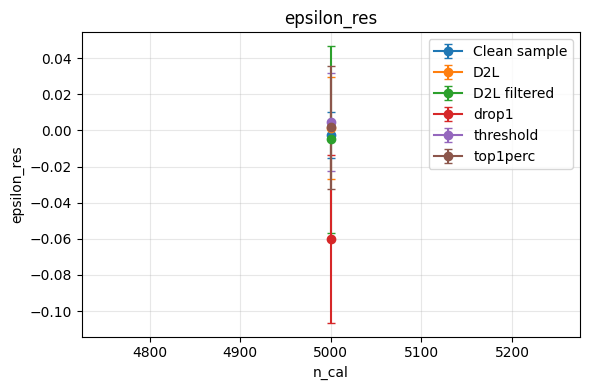

In [9]:
#summary = results.drop(columns=['seed']).groupby(['method', 'epsilon']).agg(['mean', 'std'])
summary = results.drop(columns=['seed']).replace({None: np.nan})
summary = summary.drop(columns=['model_name'])
summary = summary.drop(columns=['contamination'])
summary = summary.drop(columns=['data'])
summary = summary.groupby(['Method', 'n_cal']).agg(['mean', 'std'])
#summary = summary.groupby(['method', 'n_cal_eq']).agg(['mean', 'std'])


#metric_cols = ['tv_d', 'frobenius_d', 'frob_inv_d']
#metric_cols = ['tv_d', 'frobenius_d']
metric_cols = ['epsilon_res']

for metric in metric_cols:
    mean_vals = summary[metric]['mean'].unstack('Method')
    std_vals  = summary[metric]['std'].unstack('Method')

    plt.figure(figsize=(6, 4))
    
    for method in mean_vals.columns:
        plt.errorbar(
            mean_vals.index,
            mean_vals[method],
            yerr=std_vals[method],
            marker='o',
            linestyle='-',
            capsize=3,
            label=method
        )
    
    plt.title(f"{metric}")
    plt.xlabel("n_cal")
    #plt.xlabel("n_cal_eq")
    plt.ylabel(metric)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Working on the anchor points set

Posso io in qualche modo stimare la naturale variabilità dei dati e rimuoverla? Direi di no... Quello che posso fare è iniziare a controllare chi sono questi anchor points. Devo cercare di ripulire il set il più possibile.

Posso trovare una misura di purezza del set di anchor points prima e dopo il mio filtraggio. L'accuratezza rispetto ai label puliti forse già basta.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pdb
import copy

from sklearn.decomposition import PCA

import sys
sys.path.append("..")
sys.path.append("../third_party")


from cln import data
from cln import contamination
from cln.T_estimation import evaluate_estimate, AnchorPointsEstimation
from third_party import arc

In [31]:
# Define default parameters
data_name = 'synthetic_easy'
num_var = 20
K = 4
signal = 1
model_name = 'RFC'
epsilon = 0.2
nu = 0
contamination_model = "uniform"
n_train = 10000
n_cal = 1000
seed = 1

# Define other constant parameters
batch_size = 20
gamma_vec = np.asarray([0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2], dtype=float)

In [32]:
# Inherent variability in the simulated data
epsilon0 = 0

In [33]:
# Initialize the data distribution
if data_name == "synthetic1":
    data_distribution = data.DataModel_1(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic2":
    data_distribution = data.DataModel_2(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic3":
    data_distribution = data.DataModel_3(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic_easy":
    data_distribution = data.DataModel_1_easy(K=K, p=num_var, signal=1, epsilon0=epsilon0, random_state=seed)
else:
    print("Unknown data distribution!")
    sys.stdout.flush()
    exit(-1)

In [34]:
# Initialize noise contamination process
if contamination_model == "uniform":
    T = contamination.construct_T_matrix_simple(K, epsilon)
elif contamination_model == "block":
    T = contamination.construct_T_matrix_block(K, epsilon)
elif contamination_model == "RRB":
    T = contamination.construct_T_matrix_block_RR(K, epsilon, nu)
elif contamination_model == "random":
    T = contamination.construct_T_matrix_random(K, epsilon, random_state=seed)
else:
    print("Unknown contamination (M) model!")
    sys.stdout.flush()
    exit(-1)

In [35]:
# Initialize black-box model
if model_name == 'RFC':
    black_box = arc.black_boxes.RFC(n_estimators=100, max_features="sqrt")
elif model_name == 'SVC':
    black_box = arc.black_boxes.SVC(clip_proba_factor = 1e-5)
elif model_name == 'NN':
    black_box = arc.black_boxes.NNet(max_iter=100)
elif model_name == 'kNN':
    black_box = arc.black_boxes.NNet(max_iter=100)
else:
    print("Unknown model!")
    sys.stdout.flush()
    exit(-1)

In [36]:
random_state = 2026
data_distribution.set_seed(random_state+1)
X, Y = data_distribution.sample(n_train+n_cal)

# Generate the contaminated labels
contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+2)
Yt = contamination_process.sample_labels(Y)

# Separate data into training and calibration
X_train, X_cal, _, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal, random_state=random_state+3)

# Fit the point predictor on the training set
black_box_pt = copy.deepcopy(black_box)
black_box_pt.fit(X_train, Yt_train)

In [37]:
p_hat = black_box_pt.predict_proba(X_cal)

In [47]:
gamma_opt = 0.03

In [48]:
anchor_points = []
m = max(1, int(np.ceil(gamma_opt * n_cal)))

for l in range(K):
    scores_l = p_hat[:, l]
    top_idx = np.argsort(scores_l)[::-1][:m]
    # Update the list of anchor points
    anchor_points.append(top_idx)

In [49]:
# Evaluate quality of the set of anchor points
anchors_correct = 0
anchors_correct_tilde = 0
anchors_total = 0

for l in range(K):
    top_idx = anchor_points[l]
    Y_top = Y_cal[top_idx]
    Yt_top = Yt_cal[top_idx]
    anchors_correct += np.sum(Y_top == l)
    anchors_correct_tilde += np.sum(Yt_top == l)
    anchors_total   += len(top_idx)

accuracy_gamma = anchors_correct/anchors_total
accuracy_tilde_gamma = anchors_correct_tilde/anchors_total

In [50]:
accuracy_gamma

0.9916666666666667

In [42]:
accuracy_tilde_gamma

0.8

In [43]:
# Extract the anchor points to get anchor dataset
# Collect (index, class) pairs
anchor_pairs = []
for l in range(K):
    for idx in anchor_points[l]:
        anchor_pairs.append((int(idx), l))

# Resolve possible duplicates:
# assign each index to the class with maximal p_hat
anchor_dict = {}
for idx, l in anchor_pairs:
    if idx not in anchor_dict:
        anchor_dict[idx] = l
    else:
        # choose class with highest predicted probability
        if p_hat[idx, l] > p_hat[idx, anchor_dict[idx]]:
            anchor_dict[idx] = l

anchor_idx = np.array(sorted(anchor_dict.keys()), dtype=int)
Y_anchor = np.array([anchor_dict[i] for i in anchor_idx], dtype=int)
X_anchor = X[anchor_idx]

Display anchor points in the plane identified by the two first principal components

In [44]:
# PCA on the full calibration set
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X_cal)

# Get anchor coordinates in PCA space
Z_anchor = Z[anchor_idx]

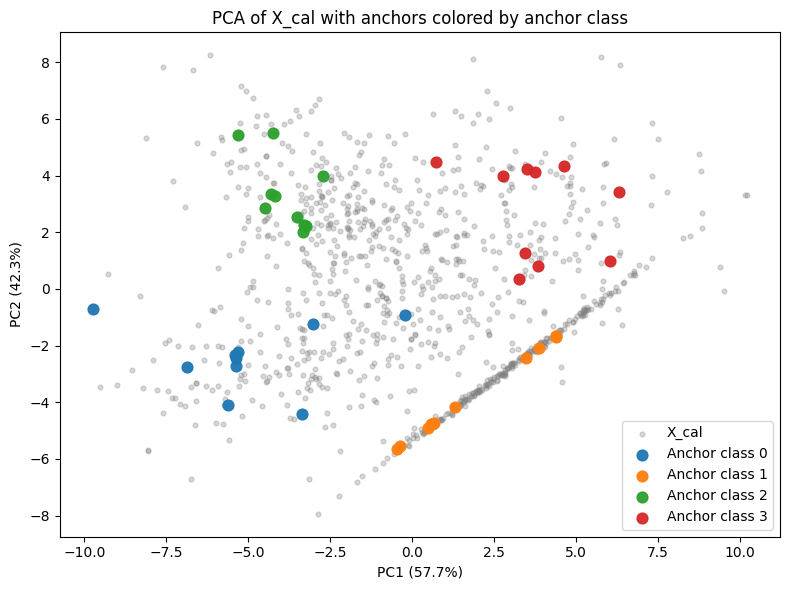

In [45]:
# Plot: all points grey; anchors colored by Y_anchor
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], c="grey", s=12, alpha=0.30, label="X_cal")

classes = np.unique(Y_anchor)
for c in classes:
    mask = (Y_anchor == c)
    plt.scatter(Z_anchor[mask, 0], Z_anchor[mask, 1],
                s=60, alpha=0.95, label=f"Anchor class {c}")

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of X_cal with anchors colored by anchor class")
plt.legend()
plt.tight_layout()
plt.show()

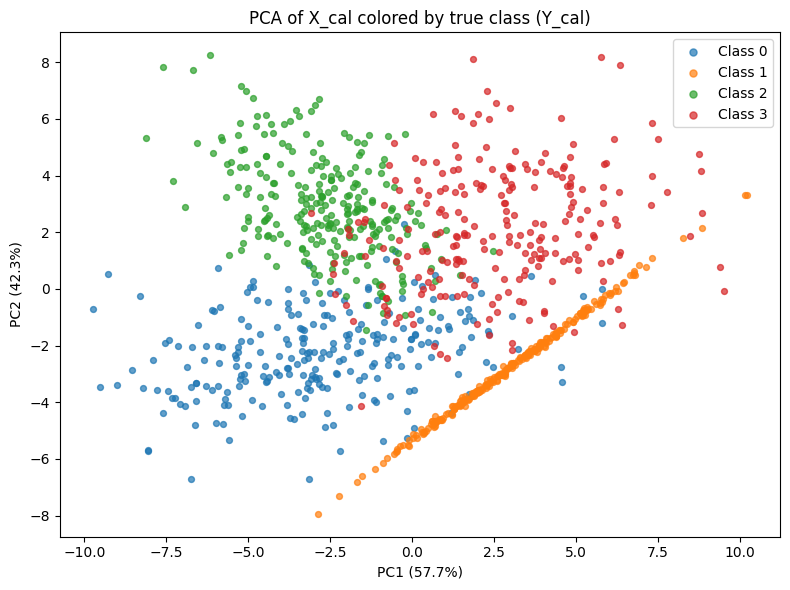

In [46]:
plt.figure(figsize=(8, 6))

classes = np.unique(Y_cal)
for c in classes:
    mask = (Y_cal == c)
    plt.scatter(Z[mask, 0], Z[mask, 1],
                s=18, alpha=0.7, label=f"Class {c}")

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of X_cal colored by true class (Y_cal)")
plt.legend(markerscale=1.2)
plt.tight_layout()
plt.show()

Evaluate and display centrality of anchor points

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [59]:
# Use true labels for class-conditional centrality:
y_class = Yt_cal   # or Yt_cal, depending on what you mean by "label is l"

# Standardize once globally (recommended)
scaler = StandardScaler()
Xc_s = scaler.fit_transform(X_cal)

is_anchor = np.zeros(X_cal.shape[0], dtype=bool)
is_anchor[anchor_idx] = True

# centrality score for all points (NaN if class too small)
centrality_knn = np.full(X_cal.shape[0], np.nan, dtype=float)

k = 20  # choose e.g. 10-50; must be < class size
for l in range(K):
    idx_l = np.where(y_class == l)[0]
    n_l = len(idx_l)
    if n_l <= 1:
        continue

    k_l = min(k, n_l - 1)

    X_l = Xc_s[idx_l]
    nn = NearestNeighbors(n_neighbors=k_l + 1).fit(X_l)
    dists, _ = nn.kneighbors(X_l)           # includes self as first neighbor (dist 0)
    mean_knn_dist = dists[:, 1:].mean(axis=1)

    centrality_knn[idx_l] = mean_knn_dist

# Anchor centralities (restricted to their assigned anchor class if you want)
anchor_centrality = centrality_knn[anchor_idx]

In [60]:
anchor_centrality

array([0.0649848 , 0.41208843, 0.34767462, 0.4849235 , 0.26342761,
       0.10523796, 1.33026621, 0.07277723, 0.7797004 , 0.4395164 ,
       0.18413381, 0.29944206, 0.14619117, 0.05077339, 0.06492007,
       1.58604525, 0.13197468, 0.30876343, 0.4730356 , 0.26266272,
       0.2605859 , 0.12983782, 0.18865014, 0.23693857, 0.46720882,
       0.04434388, 0.18720061, 0.19583798, 0.17762314, 0.51696441,
       0.34756008, 0.16895877, 0.29266353, 0.18919448, 0.67025474,
       2.47680744, 0.21160317, 0.89193842, 0.05649829, 0.16627772,
       0.53325467, 0.0578258 , 0.65155714, 0.25606187, 0.61933621,
       1.15652254, 0.17571647, 0.25751976, 1.38480003, 0.20485786,
       0.84260085, 0.06342027, 0.17990924, 0.17463454, 0.05262901,
       0.13354854, 0.53827032, 0.22702104, 0.20595077, 0.7672532 ,
       0.24371143, 1.3161111 , 0.26252792, 0.85713399, 0.15036775,
       0.30873679, 0.0566611 , 0.1135628 , 0.52649285, 0.18422336,
       0.24010822, 0.14936709, 0.03871985, 0.84759333, 0.20688

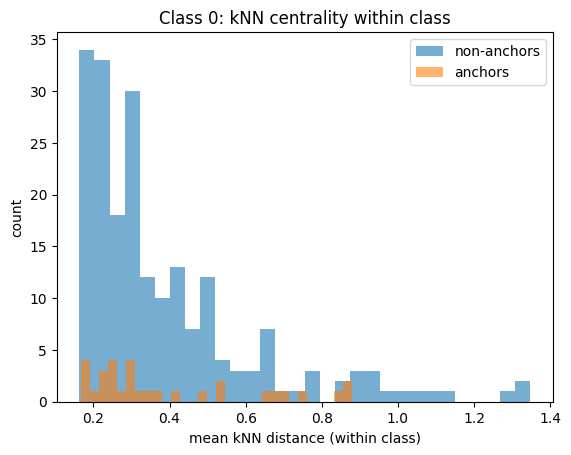

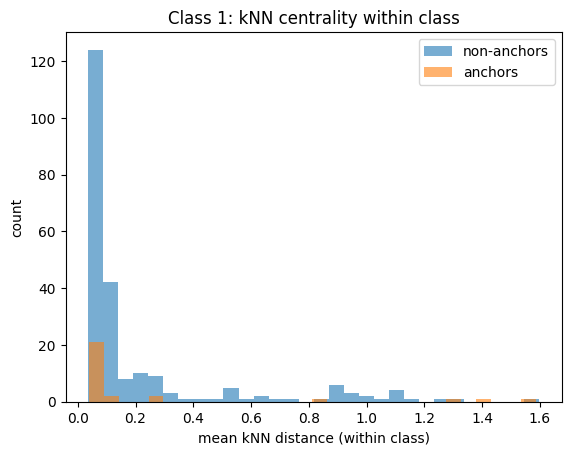

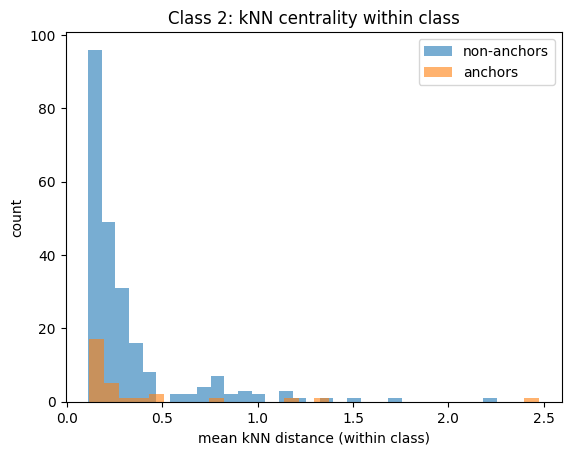

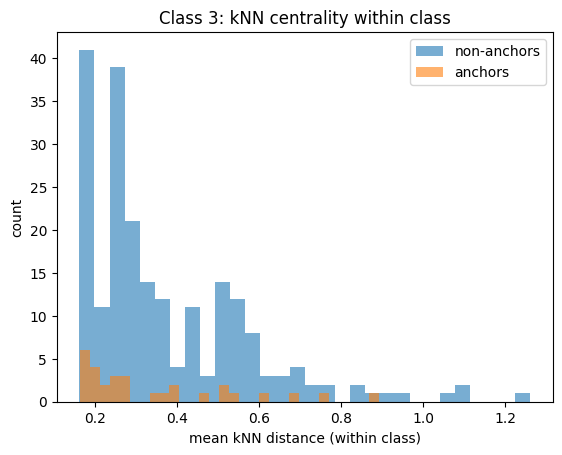

In [61]:
for l in range(K):
    idx_l = np.where(y_class == l)[0]
    idx_la = idx_l[is_anchor[idx_l]]
    idx_lna = idx_l[~is_anchor[idx_l]]

    if len(idx_l) < 5:
        continue

    plt.figure()
    plt.hist(centrality_knn[idx_lna], bins=30, alpha=0.6, label="non-anchors")
    plt.hist(centrality_knn[idx_la],  bins=30, alpha=0.6, label="anchors")
    plt.title(f"Class {l}: kNN centrality within class")
    plt.xlabel("mean kNN distance (within class)")
    plt.ylabel("count")
    plt.legend()
    plt.show()


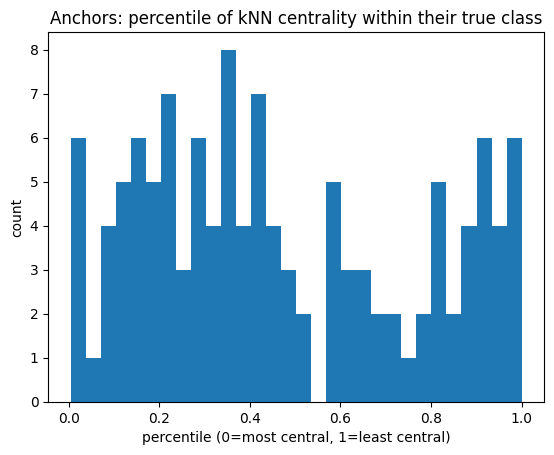

In [62]:
def within_class_percentile(scores, idx_l):
    s = scores[idx_l]
    order = np.argsort(s)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(len(s))
    return ranks / max(1, (len(s)-1))

anchor_percentile = np.full(X_cal.shape[0], np.nan)

for l in range(K):
    idx_l = np.where(y_class == l)[0]
    if len(idx_l) < 5:
        continue
    p = within_class_percentile(centrality_knn, idx_l)
    anchor_percentile[idx_l] = p

# anchors should have LOW percentile if they're central (small mean kNN dist)
plt.figure()
plt.hist(anchor_percentile[anchor_idx], bins=30)
plt.title("Anchors: percentile of kNN centrality within their true class")
plt.xlabel("percentile (0=most central, 1=least central)")
plt.ylabel("count")
plt.show()